# Flow modelling – Adding/removing/shifting flows

In [1]:
import graph_tool as gt
import graph_tool.draw
from graph_tool import util
from graph_tool import Edge, Graph, Vertex, PropertyMap
import numpy as np
import datetime
import cairo

In [2]:
print("Date:", datetime.datetime.now().date().isoformat())

Date: 2018-11-30


In [3]:
(datetime.datetime.now().date() + datetime.timedelta(days=100)).isoformat()

'2019-03-10'

## Funcitons

In [34]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_mass
        Edge property (mass), double
    vtx_mask
        Vertex property, bool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("float", vals=mass_list)
    eprop_mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    r = (False for x in g.get_vertices())
    vtx_mask = g.new_vertex_property("bool", vals=r)
    return (g, eprop_material, eprop_mass, eprop_mass_text, vtx_mask)


def define_mask(g, edges):
    """Create an edge mask for the edges that define the solution
    
    g - graph
    edges - an iterable of edge objects
    """
    cols = []
    mask = g.new_edge_property("bool")
    for i,e in enumerate(g.edges()):
        if e in edges:
            mask[e] = True
            cols.append("green")
        else:
            mask[e] = False
            cols.append("red")
    
    return (mask, g.new_edge_property("string", vals=cols))


def plot_sol_mass(g, colors, mass):
    mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass])
    gt.draw.graph_draw(g, vertex_size=20, vertex_text=g.vp.id,
                       vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors},
                       edge_text=mass_text,
                       output_size=(700,600), inline=True)

    
def plot_sol_materials(g, colors, eprop_material):
    gt.draw.graph_draw(g, vertex_size=20, vertex_text=g.vp.id,
                       vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors},
                       edge_text=eprop_material,
                       output_size=(700,600), inline=True)

## Test data Bread to Beer

In [5]:
G = gt.Graph(directed=True)
G.load("breadbeer.gt")

In [6]:
g_split, eprop_material, eprop_mass, eprop_mass_text, vtx_mask = split_flows(G)

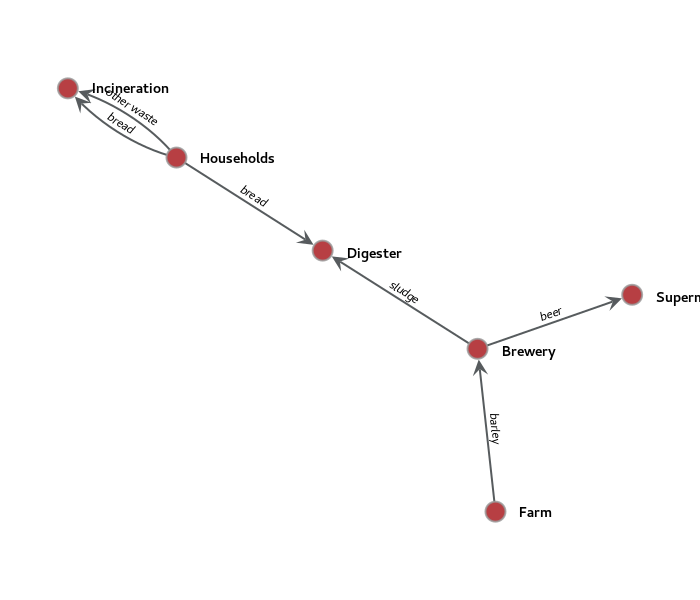

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb2233399b0, at 0x7fb225005940>

In [7]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

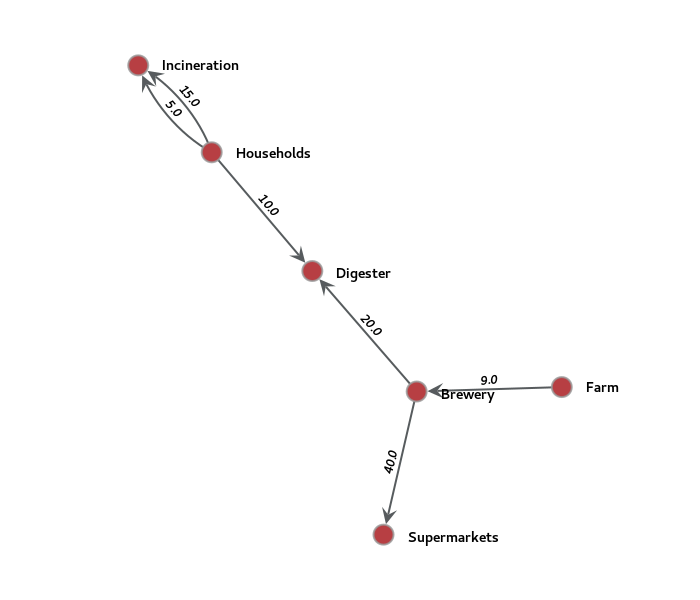

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb2233399b0, at 0x7fb225005668>

In [8]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

In [9]:
def extend_graph(G, mass, material):
    """Add a new node and flow for each node where inflow != outflow to obtain a local mass balance
    
    Returns a modified copy of the graph and edge properties
    """
    g = G.copy()
    eprop_mass = mass.copy()
    eprop_material = material.copy()
    for i, v in enumerate(g.vertices()):
        all_in = v.in_edges()
        all_out = v.out_edges()
        inflow = sum([eprop_mass[ein] for ein in all_in])
        outflow = sum([eprop_mass[out] for out in all_out])
                
        if inflow == outflow:
            break
        elif inflow < outflow:
            diff = outflow - inflow
            nv = g.add_vertex(1)
            ne = g.add_edge(nv, v)
        elif inflow > outflow:
            diff = inflow - outflow
            nv = g.add_vertex(1)
            ne = g.add_edge(v, nv)
        else:
            print('Something went terribly wrong')
            
        g.vp.id[nv] = '_temp'
        eprop_mass[ne] = diff
        eprop_material[ne] = '_temp'
        
    return (g, eprop_mass, eprop_material)

In [10]:
#g_new, emass_new, emat_new = extend_graph(g_split, eprop_mass, eprop_material)

## Solution – Bread to Beer

The solution shifts the bread waste from Households-Incineration to Households-Brewery, because the bread waste will be used to produce beer. That means that 27t of bread waste is shifted to Brewery, so a new flow is created, and one is removed.

In [11]:
# List the vertices (Activities)
for i,e in enumerate(g_split.vp["id"]):
    print(i,e)

0 Households
1 Incineration
2 Digester
3 Brewery
4 Supermarkets
5 Farm


### Shifting flows

In order to shift a flow from one activity to the other, we need to 

1. remove the existing flow

2. add the new flow

3. update the flow properties, such as flow material and mass

Also, at the end we need to compare the new situation with the existing (Status Quo), thus its neccessary to keep a copy of the existing graph and flow properties.

In [12]:
def shift_flow(G, edge_to_remove, target_vertex, eprop_material, eprop_mass, eprop_mass_text):
    """Shifts a flow by removing an existing flow and adding a new flow
    
    Return
    ------
    graph
        (Copy of the graph with the shifted flow, copies of the property maps with the shifted flow)
    """
    assert isinstance(G, Graph)
    assert isinstance(edge_to_remove, Edge)
    assert isinstance(target_vertex, Vertex)
    assert isinstance(eprop_material, PropertyMap)
    assert isinstance(eprop_mass, PropertyMap)
    assert isinstance(eprop_mass_text, PropertyMap)
    
    g = G.copy()
    mat = g.new_edge_property("string", vals=eprop_material)
    mass = g.new_edge_property("float", vals=eprop_mass)
    mass_text = g.new_edge_property("string", vals=eprop_mass_text)
    
    edge_to_add = g.add_edge(edge_to_remove.source(), target_vertex)
    mat[edge_to_add] = eprop_material[edge_to_remove]
    mass[edge_to_add] = eprop_mass[edge_to_remove]
    mass_text[edge_to_add] = eprop_mass_text[edge_to_remove]
    g.remove_edge(edge_to_remove)
    
    return (g, mat, mass, mass_text)

In [13]:
# Find edge to shift. Note that this takes O(V) time
v_source = util.find_vertex(g_split, g_split.vp["id"], "Households")
v_target = util.find_vertex(g_split, g_split.vp["id"], "Incineration")
pe = g_split.edge(v_source[0], v_target[0], all_edges=True)
edge_to_remove = [e for e in pe if eprop_material[e] == 'bread'][0] # because there are prallel edges, we need to identify them by material

v_target = util.find_vertex(g_split, g_split.vp["id"], "Brewery")[0]

In [14]:
# Shift the flow Households-->Brewery
shifted_g, shifted_material, shifted_mass, shifted_mass_text = shift_flow(g_split, \
                                                                          edge_to_remove=edge_to_remove, \
                                                                          target_vertex=v_target, \
                                                                          eprop_material=eprop_material, \
                                                                          eprop_mass=eprop_mass, \
                                                                          eprop_mass_text=eprop_mass_text)

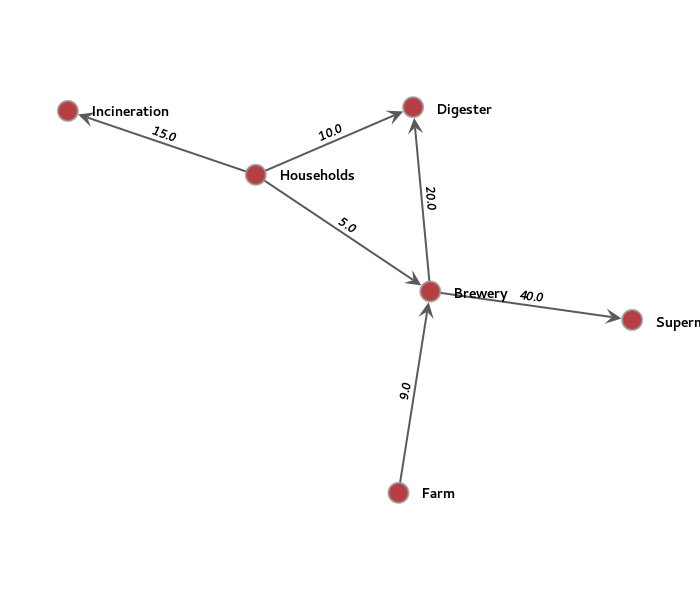

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb223021048, at 0x7fb223021978>

In [15]:
gt.draw.graph_draw(shifted_g, vertex_size=20, vertex_text=shifted_g.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text": shifted_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

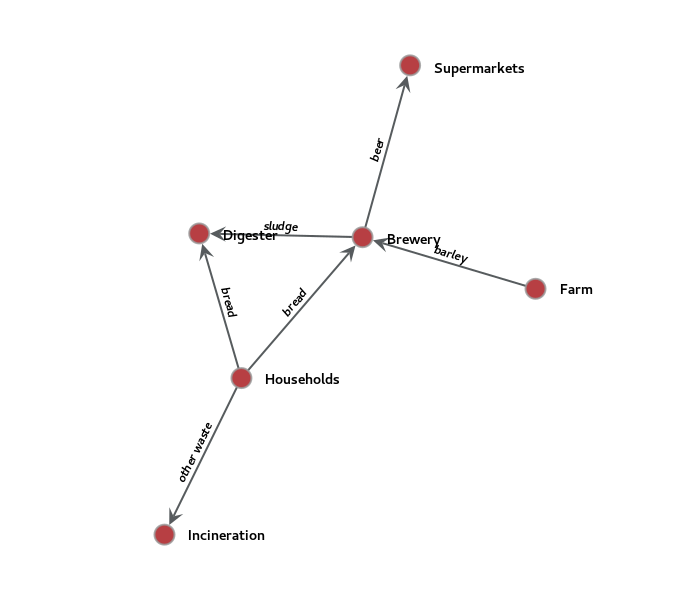

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fb223021048, at 0x7fb223021a90>

In [16]:
gt.draw.graph_draw(shifted_g, vertex_size=20, vertex_text=shifted_g.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text": shifted_material, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

### Computing the change between the status quo and the solution

We need to report what is the difference bewteen the status quo and the new graph. In the current case, we shifted a flow completely. Thus the change report should indicate

In [19]:
def compare_graphs(G1, G2):
    """Compare G2 to G1 and report the changes in vertices and edges"""
    assert "id" in G1.vertex_properties.keys()
    assert "id" in G2.vertex_properties.keys()
    vtx_removed = set(G1.vp["id"]) - set(G2.vp["id"])
    vtx_added = set(G2.vp["id"]) - set(G1.vp["id"])
    e_removed = [e for e in G1.edges() if e not in G2.edges()]
    e_added = [e for e in G2.edges() if e not in G1.edges()]
    
    print("Nodes removed from G1:", ", ".join(vtx_removed))
    print("Nodes added to G1:", ", ".join(vtx_added))
    print("\nFlows removed from G1:")
    for e in e_removed:
        print(G1.vp.id[e.source()], '-->', G1.vp.id[e.target()])
    print("\nFlows added to G1:")
    for e in e_added:
        print(G2.vp.id[e.source()], '-->', G2.vp.id[e.target()])
    pass

In [20]:
test = shifted_g.copy()
test.remove_vertex(2)

compare_graphs(g_split, test)

Nodes removed from G1: Digester
Nodes added to G1: 

Flows removed from G1:
Households --> Incineration
Households --> Digester
Brewery --> Digester

Flows added to G1:
Households --> Brewery


### Apply ratios to flows

Also, the solution defines that the Brewery can convert 500kg of bread to 4000 liters of beer. In the GDSE we deal with tons only as units, thus for now we convert this amounts to 0.5t bread to 4t beer. Thus the conversion factor is 8.

The solution is defined as:

+ shift the complete bread waste flow from 'Households --> Incinerator' to 'Households --> Brewery', this is 5t

+ this reduces the barley flow 'Farm --> Brewery'

+ everything else stays unchanged

In [35]:
solution_edges = []

v_source = util.find_vertex(shifted_g, shifted_g.vp["id"], "Farm")
v_target = util.find_vertex(shifted_g, shifted_g.vp["id"], "Brewery")
e = shifted_g.edge(v_source[0], v_target[0], all_edges=True)
assert len(e) == 1, "There are parallel edges in %s --> %s" % (shifted_g.vp.id[v_source[0]], shifted_g.vp.id[v_target[0]])
solution_edges.append(e[0])

v_source = util.find_vertex(shifted_g, shifted_g.vp["id"], "Households")
v_target = util.find_vertex(shifted_g, shifted_g.vp["id"], "Brewery")
e = shifted_g.edge(v_source[0], v_target[0], all_edges=True)
assert len(e) == 1, "There are parallel edges in %s --> %s" % (shifted_g.vp.id[v_source[0]], shifted_g.vp.id[v_target[0]])
solution_edges.append(e[0])

edge_mask, ecolors = define_mask(shifted_g, solution_edges)

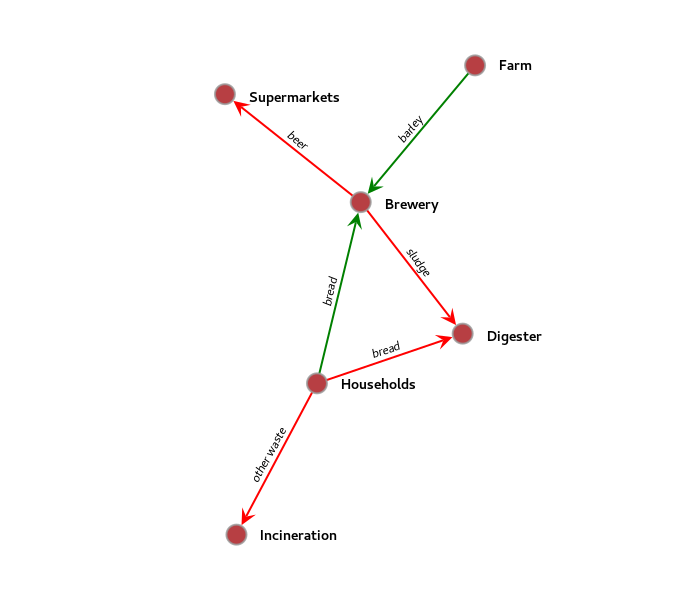

In [36]:
plot_sol_materials(shifted_g, ecolors, shifted_material)

In [ ]:
vtx_conversion = g_split.new_vertex_property("object")

In [ ]:
vtx_conversion[g_split.vertex(3)] = [ {'from':'bread', 'to':'beer', 'ratio': 8}, {'from':'bread', 'to':'sludge', 'ratio': 0.5} ]

In [ ]:
for v in g_split.vertices():
    if vtx_conversion[v]:
        print(vtx_conversion[v])

In [ ]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

In [ ]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_material, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)